In [1]:
# Importing required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense

In [2]:
# Download Axis Bank stock data
ticker="AXISBANK.NS"
df=yf.download(ticker,start='2015-01-01',end='2024-01-01')


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
df=df[['Close']]
df.dropna(inplace=True)
print(df.head())

Price            Close
Ticker     AXISBANK.NS
Date                  
2015-01-01  486.874786
2015-01-02  497.763031
2015-01-05  500.908539
2015-01-06  483.003418
2015-01-07  482.616241


<ipython-input-3-fb357eebba72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [4]:
# DATA PREPROCESSING

scaler=MinMaxScaler(feature_range=(0,1))
df['closed_scale']=scaler.fit_transform(df[['Close']])

In [5]:
# Create training and testing dataset

train_size=int(len(df)*0.8)
train_data=df.iloc[:train_size]
test_data=df.iloc[train_size:]

In [16]:
# Convert data into sequnce for LSTM

def create_sequences(data,time_steps=60):
    x,y=[],[]
    for i in range(len(data)-time_steps):
       x.append(data.iloc[i:i+time_steps]['closed_scale'].values)
       y.append(data.iloc[i+time_steps]['closed_scale'])
    return np.array(x),np.array(y)
# using past 60 days for prediction
time_steps=60
x_train,y_train=create_sequences(train_data,time_steps)
x_test,y_test=create_sequences(test_data,time_steps)

# Reshaping of the data for using LSTM
x_train=x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_test=x_test.reshape((x_test.shape[0],x_test.shape[1],1))
# Convert data into sequnce for LSTM

def create_sequences(data,time_steps=60):
    x,y=[],[]
    for i in range(len(data)-time_steps):
       x.append(data.iloc[i:i+time_steps]['closed_scale'].values)
       y.append(data.iloc[i+time_steps]['closed_scale']) # Changed here
    return np.array(x),np.array(y)
# using past 60 days for prediction
time_steps=60
x_train,y_train=create_sequences(train_data,time_steps)
x_test,y_test=create_sequences(test_data,time_steps)

# Reshaping of the data for using LSTM
x_train=x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_test=x_test.reshape((x_test.shape[0],x_test.shape[1],1))

print("Training data shape :",x_train.shape)
print("Testing data shape:",x_test.shape)


Training data shape : (1716, 60, 1)
Testing data shape: (385, 60, 1)


In [32]:
# BUILDING AND TRAINING THE LSTM MODEL

model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(time_steps,1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mse')
model.fit(x_train,y_train,epochs=1,batch_size=1,validation_data=(x_test,y_test))

1716/1716 ━━━━━━━━━━━━━━━━━━━━ 55s 30ms/step - loss: 0.0044 - val_loss: 6.5332e-04


In [33]:
# Make predictions

predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices.reshape(-1,1))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [34]:
# Evaluate model performance
from sklearn.metrics import mean_squared_error

rmse=np.sqrt(mean_squared_error(test_data.iloc[time_steps:]['Close'],predicted_prices))
print("Root Mean Squared Error:",rmse)

Root Mean Squared Error: 21.208349001815595


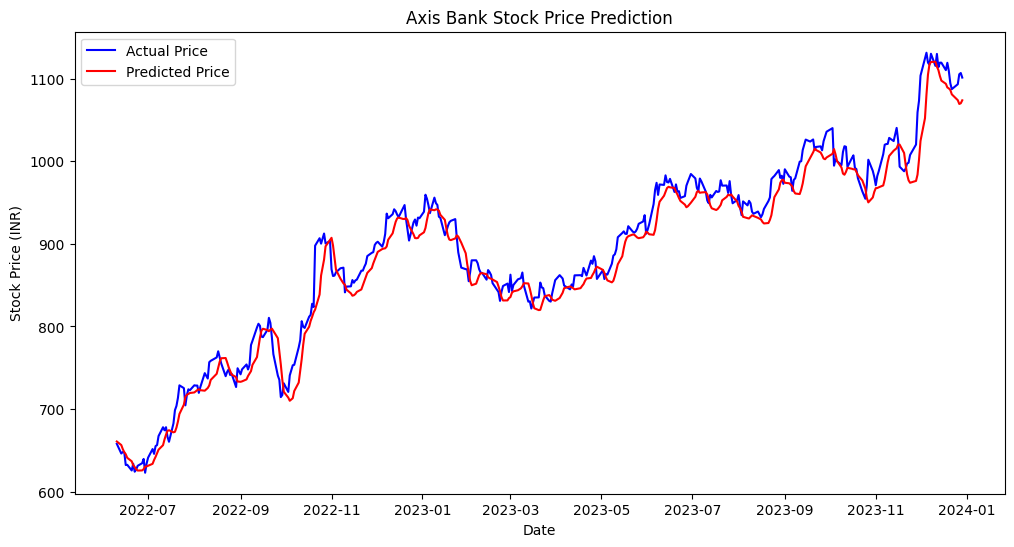

In [35]:
# Visualize Predictions
plt.figure(figsize=(12,6))
plt.plot(test_data.index[time_steps:], test_data['Close'].iloc[time_steps:], label="Actual Price", color='blue')
plt.plot(test_data.index[time_steps:], predicted_prices, label="Predicted Price", color='red')
plt.title("Axis Bank Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price (INR)")
plt.legend()
plt.show()


In [39]:
# Get last 60 days of data
last_60_days = df['closed_scale'].iloc[-time_steps:].values.reshape(1, time_steps, 1)

# Predict future price
future_price = model.predict(last_60_days)
future_price = scaler.inverse_transform(future_price)

print("Predicted Next Day Price:", future_price[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Next Day Price: 1076.959
